In [ ]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning

In [2]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.algorithms import QSVC
from qiskit_algorithms.optimizers import SPSA
from qiskit_machine_learning.utils.loss_functions import SVCLoss
from qiskit_machine_learning.kernels.algorithms.quantum_kernel_trainer import QuantumKernelTrainer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from torchvision import transforms

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Define dataset paths
##### !!! Remove .DS_Store from folders

In [5]:
# !rm -rf {path}/chest_xray/chest_xray/train/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/train/PNEUMONIA/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/NORMAL/.DS_Store
# !rm -rf {path}/chest_xray/chest_xray/test/PNEUMONIA/.DS_Store

In [6]:
train_path_norm = f'{path}/chest_xray/chest_xray/train/NORMAL'
train_path_pneu = f'{path}/chest_xray/chest_xray/train/PNEUMONIA'
test_path_norm = f'{path}/chest_xray/chest_xray/test/NORMAL'
test_path_pneu = f'{path}/chest_xray/chest_xray/test/PNEUMONIA'

#### Check data

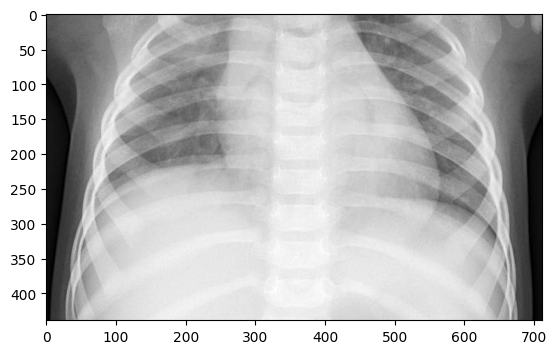

In [7]:
xray_image = cv2.imread(f'{train_path_pneu}/person1_bacteria_1.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

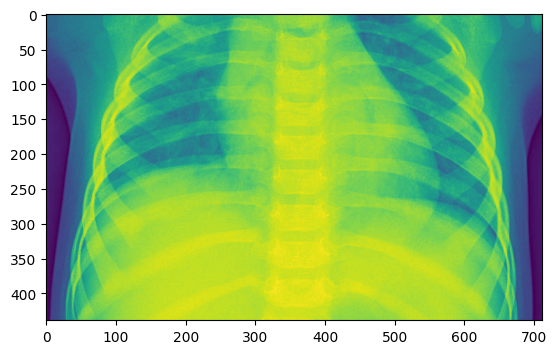

In [8]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Load and preprocess the images

In [9]:
img_size = (128, 128)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_images_from_folder(folder, label, transform):
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            img_array = img.numpy().flatten()
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, transform):
    data, labels = load_images_from_folder(path, label, transform)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Load data with a smaller sample size for experimentation

In [10]:
train_data_norm, train_labels_norm = load_and_limit_data(train_path_norm, 0, 150, transform)
train_data_pneu, train_labels_pneu = load_and_limit_data(train_path_pneu, 1, 150, transform)
X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

#### Apply PCA with 4 components to match the reduced number of qubits

In [11]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

#### Load and prepare test data

In [12]:
test_data_norm, test_labels_norm = load_and_limit_data(test_path_norm, 0, 30, transform)
test_data_pneu, test_labels_pneu = load_and_limit_data(test_path_pneu, 1, 30, transform)
X_test = np.asarray(test_data_norm + test_data_pneu)
y_test = np.asarray(test_labels_norm + test_labels_pneu)
X_test_pca = pca.transform(X_test)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Plot the data

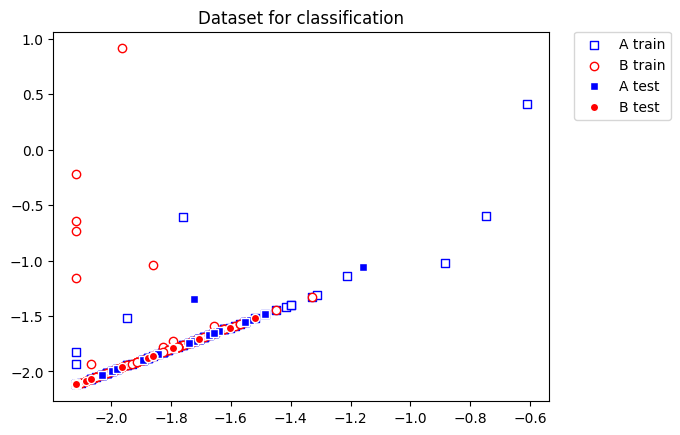

In [13]:
plt.scatter(
    X_train[np.where(y_train[:] == 0), 0],
    X_train[np.where(y_train[:] == 0), 1],
    marker="s",
    facecolors="w",
    edgecolors="b",
    label="A train",
)
plt.scatter(
    X_train[np.where(y_train[:] == 1), 0],
    X_train[np.where(y_train[:] == 1), 1],
    marker="o",
    facecolors="w",
    edgecolors="r",
    label="B train",
)
plt.scatter(
    X_test[np.where(y_test[:] == 0), 0],
    X_test[np.where(y_test[:] == 0), 1],
    marker="s",
    facecolors="b",
    edgecolors="w",
    label="A test",
)
plt.scatter(
    X_test[np.where(y_test[:] == 1), 0],
    X_test[np.where(y_test[:] == 1), 1],
    marker="o",
    facecolors="r",
    edgecolors="w",
    label="B test",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for classification")

plt.show()

#### Define the Callback wrapper class

In [14]:
class QKTCallback:
    """Callback wrapper class."""
    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        '''
        Args:
            xO: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        '''
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self) :
        return self._data

    def clear_callback_data (self) :
        self._data = [[] for i in range(5)]

#### Quantum Circuit

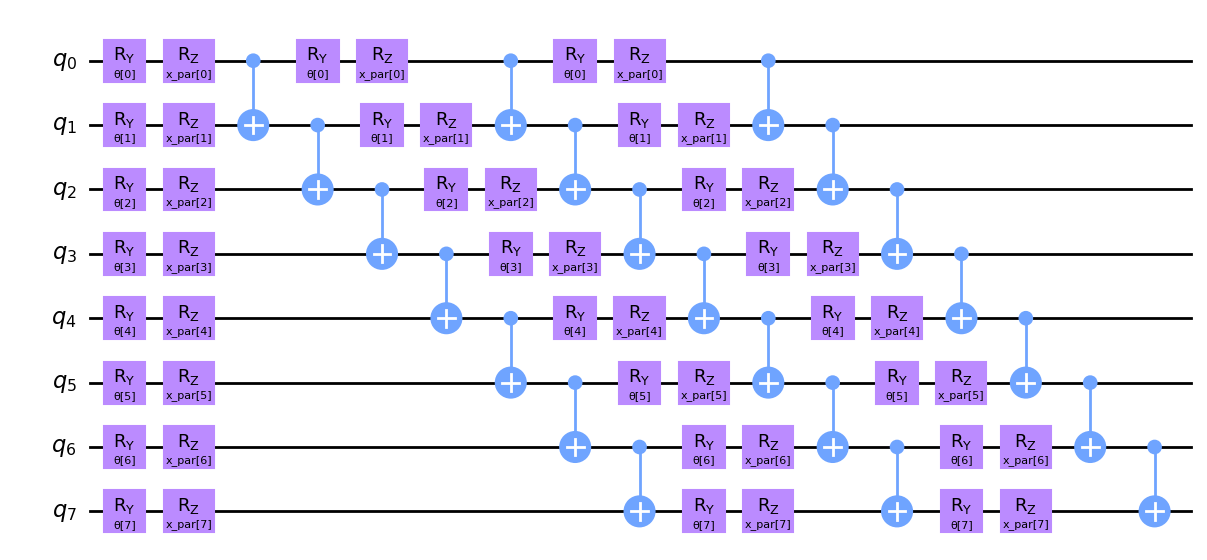

In [15]:
num_qubits = 8
qc = QuantumCircuit(num_qubits)
input_params = ParameterVector("x_par", num_qubits)
training_params = ParameterVector("θ", num_qubits)

for _ in range(3):
    for i, param in enumerate(training_params):
        qc.ry(param, qc.qubits[i])
    for i, param in enumerate(input_params):
        qc.rz(param, qc.qubits[i])
    qc.cx(0, 1)
    qc.cx(1, 2)
    qc.cx(2, 3)
    qc.cx(3, 4)
    qc.cx(4, 5)
    qc.cx(5, 6)
    qc.cx(6, 7)

qc.draw("mpl", style="clifford")

#### Initialize the optimizer, Set Up the Quantum Kernel and Quantum Kernel Trainer

In [16]:
quant_kernel = TrainableFidelityQuantumKernel(
    feature_map=qc,
    training_parameters=training_params,
)
initial_point = np.random.randn(num_qubits) * 0.1
cb_qkt = QKTCallback()
spsa_opt = SPSA(
    maxiter=10,
    callback=cb_qkt.callback,
    learning_rate=0.02,
    perturbation=0.01
)

qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel,
    loss=SVCLoss(),
    optimizer=spsa_opt,
    initial_point=initial_point
)

#### Tain the Quantum Kernel Trainer

In [17]:
qka_results = qkt.fit(X_train_tensor, y_train_tensor)

optimized_kernel = qka_results.quantum_kernel

#### Fit the QSVC, Predict the labels, Evalaute the test accuracy

In [18]:
qsvc = QSVC(quantum_kernel=optimized_kernel)

qsvc.fit(X_train_tensor, y_train_tensor)

labels_test = qsvc.predict(X_test_tensor)

accuracy_test = metrics.balanced_accuracy_score(y_true=y_test_tensor, y_pred=labels_test)

print(f"accuracy test: {accuracy_test}")

accuracy test: 0.7


#### Compute evaluation metrics

In [19]:
classification_rep = metrics.classification_report(y_test_tensor, labels_test, output_dict=True)
conf_matrix = metrics.confusion_matrix(y_test_tensor, labels_test)
roc_auc = metrics.roc_auc_score(y_test_tensor, qsvc.decision_function(X_test_tensor))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0.0': {'precision': 0.6875, 'recall': 0.7333333333333333, 'f1-score': 0.7096774193548387, 'support': 30.0}, '1.0': {'precision': 0.7142857142857143, 'recall': 0.6666666666666666, 'f1-score': 0.6896551724137931, 'support': 30.0}, 'accuracy': 0.7, 'macro avg': {'precision': 0.7008928571428572, 'recall': 0.7, 'f1-score': 0.699666295884316, 'support': 60.0}, 'weighted avg': {'precision': 0.7008928571428572, 'recall': 0.7, 'f1-score': 0.6996662958843161, 'support': 60.0}}
Confusion Matrix:
 [[22  8]
 [10 20]]
ROC AUC Score: 0.74


#### Plot the confusion matrix

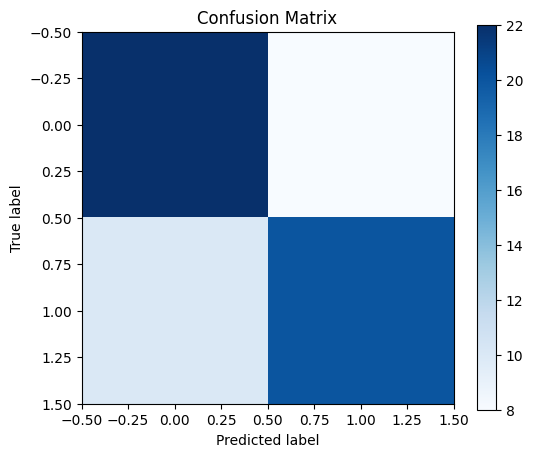

In [20]:
plt.figure(figsize=(6, 5))
plt.title("Confusion Matrix")
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### Plot the ROC curve

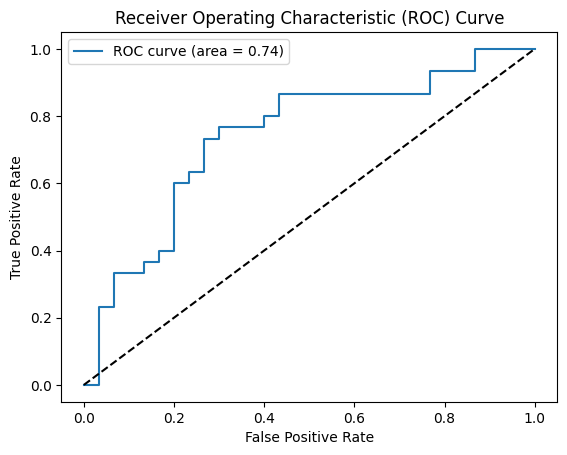

In [21]:
fpr, tpr, _ = metrics.roc_curve(y_test_tensor, qsvc.decision_function(X_test_tensor))
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")
plt.show()

#### Plot the loss

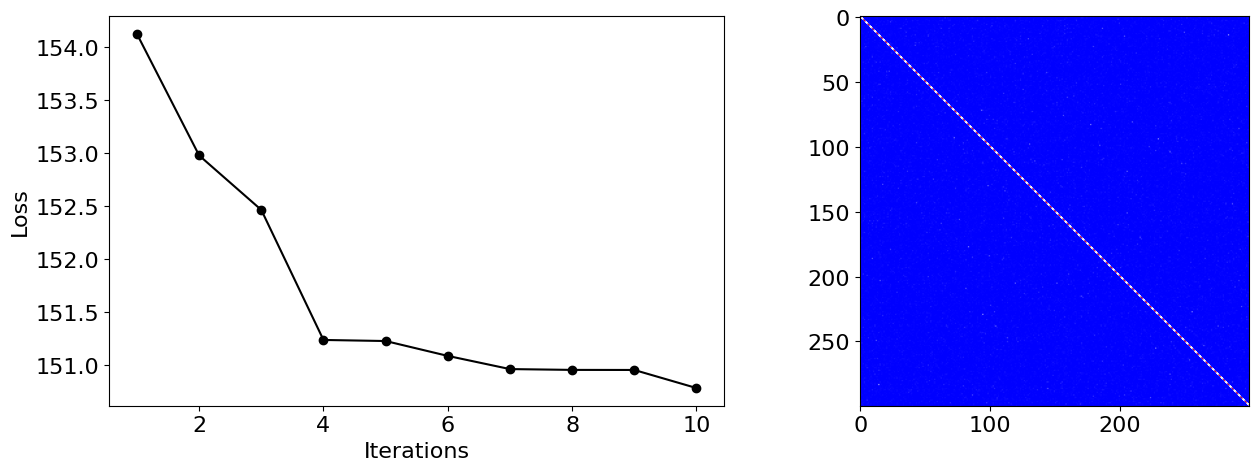

In [22]:
plot_data = cb_qkt.get_callback_data()
K = optimized_kernel.evaluate(X_train_tensor)
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel ("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=plt.colormaps["bwr"])
fig.tight_layout()
plt.show()

In [23]:
import tutorial_magics

%qiskit_version_table
%qiskit_copyright